## Question 3

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st # For MAP classifer

np.random.seed(0)

In [75]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# skorch (PyTorch wrapper for scikit-learn)
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler

# CV utilities
from sklearn.model_selection import StratifiedKFold, GridSearchCV

torch.manual_seed(0)

#### Create data distribution parameters

In [76]:
num_class = 4
dimension = 3
priors = [0.25, 0.25, 0.25, 0.25]

In [77]:
# means for each of the four classes
means = [[0, 0, 0], [3, 0, 0], [0, 3, 0], [0, 0, 3]]

# covariance matrix for each of the four classes
covs = [
    [[1.0, 0.2, 0.1], [0.2, 1.0, 0.1], [0.1, 0.1, 1.0]],
    [[1.0, -0.3, 0.0], [-0.3, 1.5, 0.2], [0.0, 0.2, 1.0]],
    [[1.2, 0.0, 0.2], [0.0, 1.0, 0.3], [0.2, 0.3, 1.5]],
    [[1.0, 0.1, -0.2], [0.1, 1.3, 0.1], [-0.2, 0.1, 1.2]],
]

#### Sample data

In [78]:
def sample_data(num_samples):
    X_list = []
    y_list = []
    for c in range(num_class):
        X_class_sample = np.random.multivariate_normal(means[c], covs[c], num_samples) # generate samples for current class
        y_class_sample = np.full(num_samples, c) # generate labels for current class
        # append to list
        X_list.append(X_class_sample)
        y_list.append(y_class_sample)
    
    # concatenate for final dataset
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list)

    # shuffle dataset for randomness
    idx = np.random.permutation(len(y)) # Not required, maybe change later to return x, y directly
    return X[idx], y[idx]

# Testing sample
X, y = sample_data(800)
print(X.dtype)
print(y.dtype)
print(f"Sampled X shape: {X.shape}")
print(f"Sampled y shape: {y.shape}")
print(f"Class counts: {np.bincount(y)}")

float64
int32
Sampled X shape: (3200, 3)
Sampled y shape: (3200,)
Class counts: [800 800 800 800]


In [79]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()

# plot each class
for c in range(num_class):
    pts = X[y == c] # points for current class
    # plot points
    fig.add_trace(go.Scatter3d(
        x=pts[:,0], y=pts[:,1], z=pts[:,2],
        mode='markers',
        marker=dict(size=2, opacity=0.35),
        name=f"Class {c}"
    ))
    # plot mean
    fig.add_trace(go.Scatter3d(
        x=[means[c][0]], y=[means[c][1]], z=[means[c][2]],
        mode='markers',
        marker=dict(size=6, symbol='diamond', line=dict(width=1, color='black')),
        name=f"Mean {c}"
    ))

# add labels
fig.update_layout(
    title="True data distribution for the four classes",
    scene=dict(xaxis_title='x1', yaxis_title='x2', zaxis_title='x3'),
    legend=dict(x=1.02, y=1.0),
    margin=dict(l=0, r=0, t=40, b=0),
)

fig.show()

#### MAP Classifier

In [80]:
def map_predict_single(x):
    """Return argmax_c p(x|c)*P(c) using true Gaussians."""
    post_unnorm = []
    for c in range(num_class):
        likelihood = st.multivariate_normal.pdf(x, mean=means[c], cov=covs[c])
        post_unnorm.append(likelihood * priors[c])
    return np.argmax(post_unnorm)

def map_predict(X):
    return np.array([map_predict_single(xi) for xi in X])

#### Optimal classifer error

In [81]:
# test dataset of 100000 samples (25000 for each class)
X_test, y_test = sample_data((100000 // num_class))
print(X_test.dtype)
print(y_test.dtype)
print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")

y_pred = map_predict(X_test)
print(f"MAP classifer accuracy: {np.mean(y_pred == y_test)}")
print(f"MAP classifer error: {np.mean(y_pred != y_test)}")

bayes_error = np.mean(y_pred != y_test)

float64
int32
Test X shape: (100000, 3)
Test y shape: (100000,)
MAP classifer accuracy: 0.88681
MAP classifer error: 0.11319


### MLP classifer

In [82]:
# Experiment grid
train_sizes = [100, 500, 1000, 5000, 10000]
test_size = 100000
P_list = [2, 4, 8, 16, 32]

# Training hyperparams
epochs = 100
batch_size = 64
patience = 10
LR = 1e-3

In [83]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=3, hidden_units=8, output_size=4):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.elu(x) # RELU, ELU, etc.
        x = self.fc2(x)
        return x

# print network architecture (Example)
model = MLP(dimension, 8, num_class)
print(model)

MLP(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
)


In [85]:
from skorch.dataset import ValidSplit

def Train_model(X_train, y_train, X_test, y_test, P_list, EPOCHS, BATCH_SIZE, PATIENCE, LR, seeds=(0,1,2), device=device,):
    print(f"\n----------------- Training with N={len(X_train)} -----------------")
    # create model
    base = NeuralNetClassifier(
        module=MLP,
        module__input_size=dimension,
        module__output_size=num_class,
        optimizer=torch.optim.Adam, # Adam over SGD
        criterion=nn.CrossEntropyLoss, # CrossEntropyLoss applies softmax internally
        max_epochs=EPOCHS,
        lr=LR,
        batch_size=BATCH_SIZE,
        device=device,
        train_split=ValidSplit(0.2, random_state=0),
        callbacks=[
            EarlyStopping(patience=PATIENCE, monitor='valid_loss'),
            LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', patience=max(PATIENCE // 2, 1)),
        ]
    )

    # Cross-validation to select P
    print("-> Running 10-fold CV to select P ...")
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    gs = GridSearchCV(
        estimator=base,
        param_grid={'module__hidden_units': list(P_list)},
        scoring='accuracy',
        cv=cv,
        n_jobs=8,
        verbose=2,
    )

    # convert type
    X_train = X_train.astype(np.float32)
    y_train = y_train.astype(np.int64)
    X_test = X_test.astype(np.float32)
    y_test = y_test.astype(np.int64)

    # Fit the model
    gs.fit(X_train, y_train)
    best_P = gs.best_params_['module__hidden_units'] # Get best number of perceptons
    print(f"-> CV chose P = {best_P} (best mean CV acc = {gs.best_score_:.4f})")

    # Three random restarts to reinitialize with new seed each restart
    best_model, best_loss = None, float('inf')
    for s in seeds:
        print(f"\n-> Retraining full train set with P={best_P}, seed={s}")
        curr_model = base.initialize()
        curr_model.set_params(module__hidden_units=best_P)
        
        np.random.seed(s)
        torch.manual_seed(s)

        curr_model.fit(X_train, y_train) # fit current model

        # Get history and loss
        hist = curr_model.history[-1]
        train_loss = float(hist['train_loss'])
        val_loss = float(hist.get('valid_loss', np.nan))

        epochs_run = len(curr_model.history)
        print(f"finished in {epochs_run} epochs | train_loss={train_loss:.4f} | valid_loss={val_loss:.4f}")

        # Save best model
        if train_loss < best_loss:
            best_loss, best_model = train_loss, curr_model
            print(" -> current best by training loss")

    # Compute empirical test error (on full test set)
    y_pred = best_model.predict(X_test)
    test_error = float(np.mean(y_pred != y_test))
    print(f"\n----------------- Test error: {test_error:.4f} -----------------")

    return best_P, test_error

In [86]:
results = []
for N in train_sizes:
    n_per_class = N // num_class # divide by number of classes to get number of samples per class
    X_train, y_train = sample_data(n_per_class)

    # Compute error and best P
    best_P, test_err = Train_model(
        X_train, y_train, X_test, y_test,
        P_list=P_list,
        EPOCHS=epochs, 
        BATCH_SIZE=batch_size, 
        PATIENCE=patience, 
        LR=LR,
        seeds=(7,8,2)
    )
    results.append({"train_size": N, "best_P": best_P, "test_error": test_err})

results



----------------- Training with N=100 -----------------
-> Running 10-fold CV to select P ...
Fitting 10 folds for each of 5 candidates, totalling 50 fits
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        1.3626       0.0500        1.3626  0.0010  0.0280
      2        1.3292       0.2000        1.3266  0.0010  0.0075
      3        1.2973       0.3500        1.2916  0.0010  0.0060
      4        1.2663       0.4000        1.2575  0.0010  0.0070
      5        1.2361       0.4500        1.2242  0.0010  0.0060
      6        1.2068       0.4500        1.1919  0.0010  0.0060
      7        1.1784       0.5000        1.1605  0.0010  0.0075
      8        1.1508       0.5000        1.1300  0.0010  0.0060
      9        1.1241       0.6000        1.1004  0.0010  0.0050
     10        1.0983       0.6000        1.0717  0.0010  0.0060
     11        1.0733       0.6500        1.0439  0.0010  0.0060

[{'train_size': 100, 'best_P': 32, 'test_error': 0.13976},
 {'train_size': 500, 'best_P': 16, 'test_error': 0.1202},
 {'train_size': 1000, 'best_P': 8, 'test_error': 0.11462},
 {'train_size': 5000, 'best_P': 32, 'test_error': 0.11459},
 {'train_size': 10000, 'best_P': 16, 'test_error': 0.11349}]

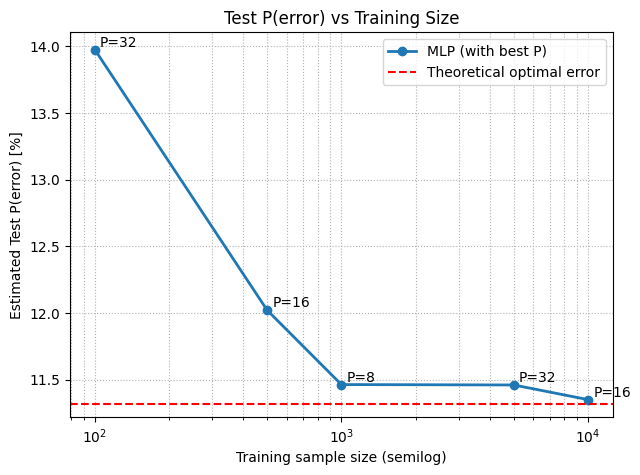

Bayes error estimate: 11.32%


In [88]:
# unpack from list of dicts
train_sizes = np.array([r["train_size"] for r in results])
test_errors = np.array([r["test_error"] for r in results])
best_Ps     = np.array([r["best_P"] for r in results])

plt.figure(figsize=(7,5))
plt.semilogx(train_sizes, test_errors * 100, marker='o', linewidth=2, label="MLP (with best P)")
plt.axhline(y=bayes_error * 100, linestyle='--', color='red', label='Theoretical optimal error')

# label each point with its chosen P
for x, y, p in zip(train_sizes, test_errors, best_Ps):
    plt.text(x * 1.05, y * 100, f"P={p}", va='bottom')

plt.xlabel("Training sample size (semilog)")
plt.ylabel("Estimated Test P(error) [%]")
plt.title("Test P(error) vs Training Size")
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()

print(f"Bayes error estimate: {bayes_error*100:.2f}%")
